In [336]:
# Imported Modules
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [337]:
# Load the image
image = cv2.imread('imgs/b_010.jpg')

# Calculate the new height based on the aspect ratio
aspect_ratio = image.shape[1] / image.shape[0]  # Setting all the images to the same size helps with minimizing different conditions we have to expect
new_width = 400
new_height = int(new_width / aspect_ratio)
new_dimensions = (new_width, new_height)

# Resize the image
image = cv2.resize(image, new_dimensions)

# Convert the image to RGB color space
rgb_img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # This is done simply so we can have the image in different variations that we can use later on
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# Convert the image to grayscale color space
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Some default parameters for the filtartion system later on
dist = 40
factor = 1.935
iterationsErode = 1
iterationsDilate = 1
size = 17

# Brightness of image is calculated and can be used for filter to decide how it would treat the image
average_brightness = cv2.mean(gray_image)[0]
print(average_brightness)

if average_brightness < 129:
    factor = 1.933
elif average_brightness < 97:
    factor = 5

171.32727771362588


In [338]:
lower_color = np.array([90, 100, 100])  # Lower bounds for the color blue to be detected
upper_color = np.array([120, 255, 255]) # Upper bounds for the color blue to be detected

# Create a mask to isolate the color within the specified range
color_mask = cv2.inRange(hsv_image, lower_color, upper_color)

# Calculate the percentage of presence of the color
total_pixels = np.prod(image.shape[:2]) # Like the brightness, calculating the presence of a certain color can help detect the size of the ball in the image
color_pixels = np.count_nonzero(color_mask)# We could also calculate the presence of the color red but given the dataset we have it is not needed here
blue_percentage_presence = (color_pixels / total_pixels) * 100

print(blue_percentage_presence)

# If the blue ball is large, we would set some parameters accordingly
if blue_percentage_presence > 4.4:
    dist = 2000
    factor = 2.5
    iterationsErode = 20
    iterationsDilate = 3
    size = 15

7.2456697459584305


### Image is passed through color filtration system that leaves us with only the balls of expected colors

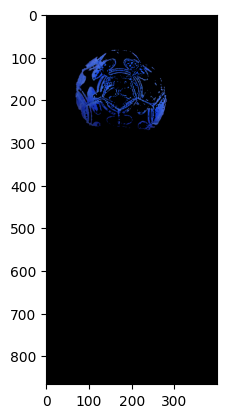

In [339]:
lower_orange = np.array([175, 140, 187])    # Orange lower bounds
upper_orange = np.array([185, 255, 255])    # Orange upper bounds

if 95<average_brightness<100 and 8<blue_percentage_presence<10: # Check for image brightness and the presence of the blue color
    lower_red = np.array([0, 150, 180])     # Red lower bounds 
    upper_red = np.array([4, 255, 250])     # Red upper bounds
else:
    lower_red = np.array([0, 150, 150])     # Red lower bounds
    upper_red = np.array([10, 255, 250])    # Red upper bounds

if 129 < average_brightness < 135:  # Check for image brightness
    lower_blue = np.array([80, 0, 0])       # Blue lower bounds
    upper_blue = np.array([130, 255, 255])  # Blue upper bounds

    lower_dblue = np.array([106, 150, 108]) # Dark blue lower bounds
    upper_dblue = np.array([121, 230, 230]) # Dark blue upper bounds

elif 95<average_brightness<100 and 8<blue_percentage_presence<10:   # Check for image brightness and the presence of the blue color
    lower_blue = np.array([104, 220, 200])  # Blue lower bounds
    upper_blue = np.array([106, 250, 255])  # Blue upper bounds

    lower_dblue = np.array([110, 200, 200]) # Dark blue lower bounds
    upper_dblue = np.array([115, 220, 200]) # Dark blue upper bounds

    factor = 1.8    # Factor used in hough circle transform set
    dist = 100      # Allowed distance between circles to be detected
else:
    lower_blue = np.array([100, 200, 255])  # Blue lower bounds
    upper_blue = np.array([116, 255, 255])  # Blue upper bounds

    lower_dblue = np.array([106, 150, 108]) # Dark blue lower bounds
    upper_dblue = np.array([121, 230, 230]) # Dark blue upper bounds

# Create a mask for red regions
mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
# Create a mask for orange regions
mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
# Create a mask blue regions
mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
# Create a mask for dark blue regions
mask_dblue = cv2.inRange(hsv_image, lower_dblue, upper_dblue)

# Combine masks to get regions with either red, orange, blue or dark blue 
combined_mask = cv2.bitwise_or(mask_red, mask_blue)
combined_mask = cv2.bitwise_or(combined_mask, mask_orange)
combined_mask = cv2.bitwise_or(combined_mask, mask_dblue)

# Set all other colors to black
result = cv2.bitwise_and(image, image, mask=combined_mask)

# Convert from BGR format to RGB format to be viewed for tuning
rgb_image=cv2.cvtColor(result, cv2.COLOR_BGR2RGB) 

# Display image
plt.imshow(rgb_image)

### Image is filtered through various means

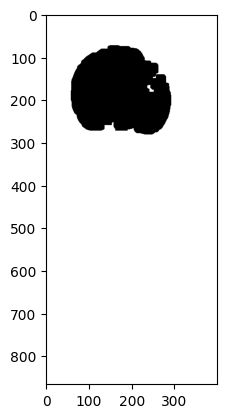

In [340]:
# Convert image to grayscale to be filtered later one
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

gray_image = cv2.GaussianBlur(gray_image,(3,3),0)   # Some linear filteration
gray_image = cv2.medianBlur(gray_image,3)

gray_image = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,4)   # Image passes through adaptive thresholding

kernel = np.ones((size,size),np.uint8)  # Kernel to be used for filteration

gray_image = cv2.erode(gray_image,kernel, iterationsErode ) # Pass image through erosion filter to highlight outer edges

if blue_percentage_presence < 4.4:  # Check for presence of the color blue
    gray_image = cv2.dilate(gray_image,kernel,iterationsDilate) # Pass through dilation filter to smoothen
                                                                        
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, factor, dist, param1=30, param2=30, minRadius=1, maxRadius=400)  # Identify circles using hough transform

plt.imshow(gray_image, cmap='gray') # Show output of filtering

### Check if circles from hough transform contain correct colors

In [341]:
temp = circles
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    threshold = 60  # Threshold when checking for red
    threshold2 = 83 # Threshold when checking for blue
    is_target_circle = [] # List of whether circles from hough transform met the right conditions or not
    
shift = -12 # Variable to be used to be shifted to check at multiple positions for specified color
for iteration in range(3):
    i=0
    for circle in circles:
        x, y, r = circle
        position = (x-20, y)
        # Check the color of the center pixel
        # Check if the x+shift coordinate is within the image boundaries
        if 0 <= x + shift < image.shape[1] and 0 <= y < image.shape[0]:
                center_color = image[y, x + shift]
        else:
                # Handle cases where the shifted coordinate is outside the image
                center_color = np.array([0, 0, 0])  # Set to a default color

        # BGR format
        target_color = np.array([30, 38, 210])    # Red in this example
        target_color2 = np.array([190, 99, 0])   # Blue in this example

        # Check if the center pixel is the target color
        is_target_color = np.all(np.abs(center_color - target_color) < threshold) or np.all(np.abs(center_color - target_color2) < threshold2)
        
                    
        # Identify color of ball
        if is_target_color:
            # Check if the center pixel is the target color
            is_target_color_red = np.all(np.abs(center_color - target_color) < threshold)
            is_target_color_blue = np.all(np.abs(center_color - target_color2) < threshold2)

            # Set color of ball detected
            if is_target_color_red and not is_target_color_blue:
                    ball_color = 'Red'
            elif is_target_color_blue and not is_target_color_red:
                    ball_color = 'Blue'

        # This part simply adds the condition True or False to a list depending on if the circles obtained from hough transform met the color conditions
        if iteration == 0:
                is_target_circle.append(is_target_color)
        else:
                is_target_circle[i] = is_target_color or is_target_circle[i]
        
        if is_target_color:
            cv2.putText(rgb_img, ball_color, position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) # Print ball color as text over image

        i+=1

        # Print results
        print(f'Center color: {center_color}')
        print(f'Is center color red or blue? {is_target_color}')
        
    shift+=20 # Shift in image to check for colors

# Some output for debugging
print(ball_color)
print(is_target_circle)

Center color: [243 147  97]
Is center color red or blue? False
Center color: [237  79  36]
Is center color red or blue? True
Center color: [245 140  97]
Is center color red or blue? False
Blue
[True]


### Draw circles over image

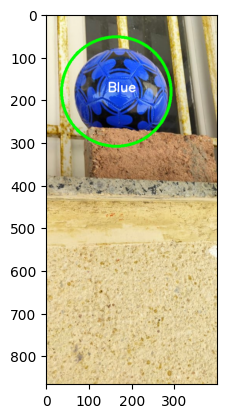

In [342]:
j = 0
if temp is not None:
    temp= np.uint16 (np.around (temp))
    for i in temp [0, :]:
        if is_target_circle[j]:
            # Draw outer circle
            cv2.circle(rgb_img, (i[0], i[1]), i[2]+20, (0, 255, 0), 5)
            # Draw center
            cv2.circle(rgb_img, (i[0], i[1]), 1, (0, 0, 0), 0)

        j+=1
plt.imshow(rgb_img) # Print final output